# Wstęp do multimediów - Laboratorium 5

Statystyczne właściwości obrazów

Bartłomiej Krawczyk
310774

Grupa 103

In [169]:
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image, display

## Pliki

In [170]:
IMAGE_DIR = './images/'
IMAGE_COL = IMAGE_DIR + 'latarnia2_col.png'
IMAGE_MONO = IMAGE_DIR + 'latarnia2_mono.png'


In [171]:
OUTPUT_IMAGE_FILE_PATH = './output/output.png'

def show_image(image):
    if (image.dtype == np.float32) or (image.dtype == np.float64):
        image = image / 255
    if image.dtype == np.int16:
        image = ((image + 255) // 2).astype(np.uint8)
    cv2.imwrite(OUTPUT_IMAGE_FILE_PATH, image)
    display(Image(filename=OUTPUT_IMAGE_FILE_PATH))


W sprawozdaniu należy zamieścić wyniki uzyskane dla obrazu testowego, wybranego na podstawie numeru indeksu w następujący sposób: 

`numer_obrazu = numer_indeksu % liczba_obrazow`

gdzie  numer  obrazu  wskazuje  pozycję pliku na posortowanej alfabetycznie liście nazw plików  testowych (pozycje numerowane od 0, tak jak elementy list w Pythonie), a % oznacza operację modulo). 

## Wylosowany Obraz

In [172]:
image_number = 310774 % 36
print(f'{image_number = }')

image_number = 22


Obraz o numerze 22 to `latarnia2`.

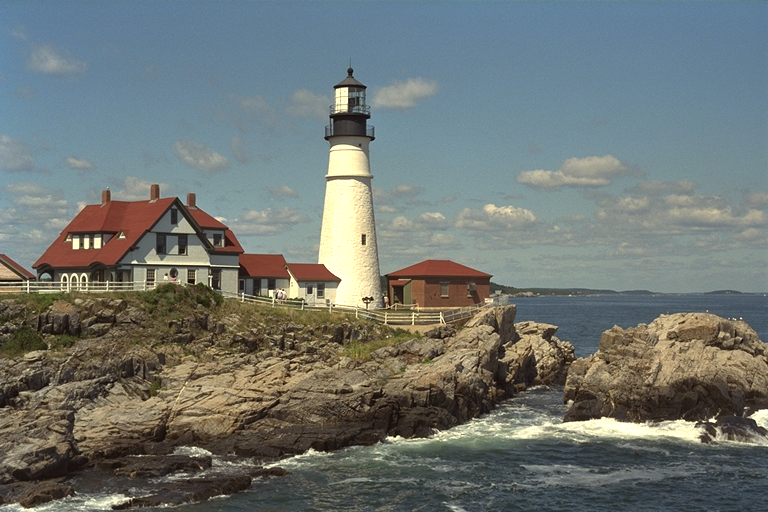

In [173]:
image_col = cv2.imread(IMAGE_COL, cv2.IMREAD_UNCHANGED)
show_image(image_col)

# Obraz Monochromatyczny

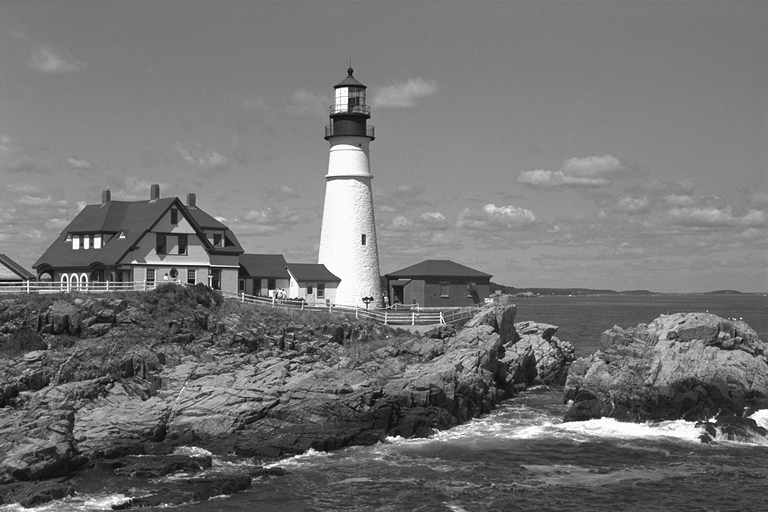

In [174]:
image_mono = cv2.imread(IMAGE_MONO, cv2.IMREAD_UNCHANGED)
show_image(image_mono)

Obliczyć  przepływność  (liczbę  bitów  przypadającą  na  jeden  piksel)  dla  obrazu  skompresowanego koderem PNG (obraz wejściowy). 

In [175]:
def calculate_bitrate(image_name):
    """
    Obliczenie średniej bitowej dla pliku .png
    os.stat() podaje rozmiar pliku w bajtach, a potrzebny jest w bitach (-> '8*')
    """
    image = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
    bitrate = 8*os.stat(image_name).st_size / (image.shape[0]*image.shape[1])
    print(f"bitrate: {bitrate:.4f}")

calculate_bitrate(IMAGE_MONO)

bitrate: 5.0608


Obliczyć entropię obrazu i porównać ją z wyliczoną przepływnością. 

Czy przepływność mniejsza od entropii oznacza, że zależność: lśr ≥ H jest nieprawdziwa?

In [181]:
def generate_histogram(image, size):
    """
    cv2.calcHist() zwraca histogram w postaci tablicy 2D,
    do dalszego przetwarzania wygodniejsza może być tablica jednowymiarowa -> flatten().
    """
    hist = cv2.calcHist([image], [0], None, [size - 1], [0, size - 1])
    hist = hist.flatten()
    return hist
    
def calculate_entropy(hist):
    """
    Obliczanie entropii
    """
    pdf = hist/hist.sum()  # normalizacja histogramu -> rozkład prawdopodobieństwa; UWAGA: niebezpieczeństwo '/0' dla 'zerowego' histogramu!!!
    # entropy = -(pdf*np.log2(pdf)).sum() ### zapis na tablicach, ale problem z '/0'
    entropy = -sum([x*np.log2(x) for x in pdf if x != 0])
    return entropy


H_image = calculate_entropy(generate_histogram(image_mono, 256))
print(f"H(image) = {H_image:.4f}")


H(image) = 7.0379


> Czy przepływność mniejsza od entropii oznacza, że zależność: lśr ≥ H jest nieprawdziwa?

...

Wyznaczyć  obraz  różnicowy  w  taki  sposób,  że  wartość  każdego  piksela  zastępowana  jest  różnicą pomiędzy  wartością  tego  piksela  a  wartością  jego  lewego  sąsiada  (kodowanie  różnicowe / predykcyjne).  Dla  pierwszego piksela w linii należy przyjąć wartość sąsiada równą 127  (środkowa 
wartość przedziału zmienności wartości pikseli).

Wyświetlić obraz różnicowy.

`Uwaga`: należy pamiętać, że wartości pikseli w obrazie różnicowym są z zakresu [-255; 255]! 

In [177]:
def printi(img, img_title="image"):
    """ Pomocnicza funkcja do wypisania informacji o obrazie. """
    print(f"{img_title}, wymiary: {img.shape}, typ danych: {img.dtype}, wartości: {img.min()} - {img.max()}")

image_hdiff, wymiary: (512, 768), typ danych: int16, wartości: -190 - 191


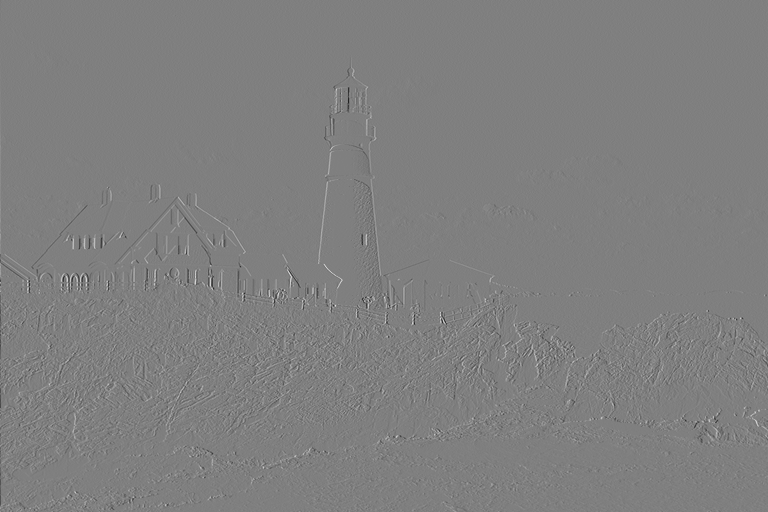

In [178]:
def differential_image(image):
    """
    Predykcja w kierunku poziomym:
    od wartości danego piksela odejmowana jest wartość piksela z lewej strony - 'lewego sąsiada' (operacje na kolumnach).
    Operację taką można wykonać dla pikseli leżących w drugiej i kolejnych kolumnach obrazu, z pominięciem skrajnie lewej kolumny.
    """
    img_tmp1 = image[:,
                    1:]  # wszystkie wiersze (':'), kolumny od 'pierwszej' do ostatniej ('1:')
    # wszystkie wiersze, kolumny od 'zerowej' do przedostatniej (':-1')
    img_tmp2 = image[:, :-1]

    """
    W wyniku odejmowania pojawią się wartości ujemne - zakres wartości pikseli w obrazie różnicowym to będzie [-255, 255],
    dlatego trzeba zmienić typ wartości pikseli, żeby zakres wartości nie ograniczał się do [0, 255];
    może to być np. cv2.CV_16S (odpowiednio np.int16 w NumPy), żeby pozostać w domenie liczb całkowitych.
    """
    image_hdiff = cv2.addWeighted(img_tmp1, 1, img_tmp2, -1, 0, dtype=cv2.CV_16S)
    """
    image_hdiff ma o jedną kolumnę mniej - dla skrajnie lewej kolumny nie było danych do odejmowania,
    kolumnę tę można potraktować oddzielnie i 'połączyć' wyniki.
    """
    image_hdiff_0 = cv2.addWeighted(
        image[:, 0], 1, 0, 0, -127, dtype=cv2.CV_16S)  # od 'zerowej' kolumny obrazu oryginalnego odejmowana stała wartość '127'
    # połączenie tablic w kierunku poziomym, czyli 'kolumna za kolumną'
    image_hdiff = np.hstack((image_hdiff_0, image_hdiff))
    printi(image_hdiff, "image_hdiff")

    show_image(image_hdiff)

    return image_hdiff

image_hdiff = differential_image(image_mono)


Wyznaczyć histogram obrazu różnicowego i porównać go z histogramem obrazu oryginalnego.   

Wyznaczyć entropię obrazu różnicowego i porównać ją z entropią obrazu oryginalnego.   

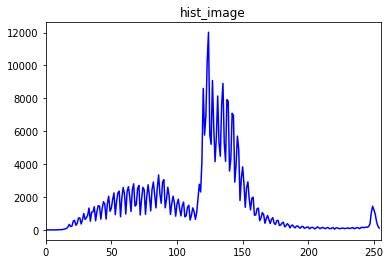

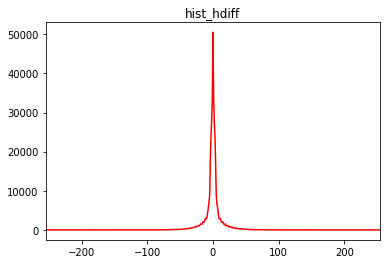

<Figure size 432x288 with 0 Axes>

H(image_mono) = 7.0379
H(hdiff) = 5.0365


In [183]:
""" Entropia dla obrazów różnicowych """

"""
cv2.calcHist() wymaga danych w formacie liczb całkowitych bez znaku (8- lub 16-bitowych) lub 32-bitowych liczb rzeczywistych,
dlatego wartości pikseli są przesuwane z zakresu [-255, 255] do [0, 510] (-> '+255')
oraz konwertowane na typ np.uint16 (-> astype()).
"""

hist_image = generate_histogram(image_mono, 256)

image_tmp = (image_hdiff+255).astype(np.uint16)
hist_hdiff = generate_histogram(image_tmp, 512)
H_hdiff = calculate_entropy(hist_hdiff)

""" Wyświetlenie histogramów z wykorzystaniem matplotlib.pyplot """
plt.figure()
plt.plot(hist_image, color="blue")
plt.title("hist_image")
plt.xlim([0, 255])
plt.figure()
# jawne podane wartości 'x' i 'y', żeby zmienić opisy na osi poziomej
plt.plot(np.arange(-255, 256, 1), hist_hdiff, color="red")
plt.title("hist_hdiff")
plt.xlim([-255, 255])
plt.figure()

plt.show()

print(f"H(image_mono) = {H_image:.4f}")
print(f"H(hdiff) = {H_hdiff:.4f}")


> Wyznaczyć histogram obrazu różnicowego i porównać go z histogramem obrazu oryginalnego.   
...
> Wyznaczyć entropię obrazu różnicowego i porównać ją z entropią obrazu oryginalnego.  
...

Wyznaczyć współczynniki DWT korzystając z funkcji zamieszczonej w przykładowym skrypcie.

Wyświetlić poszczególne pasma.   

`Uwaga`: należy pamiętać, że wartości w pasmach LH, HL i HH są z zakresu [-255, 255]!

LL, wymiary: (256, 384), typ danych: uint8, wartości: 0 - 255
LH, wymiary: (256, 384), typ danych: int16, wartości: -149 - 158
HL, wymiary: (256, 384), typ danych: int16, wartości: -132 - 158
HH, wymiary: (256, 384), typ danych: int16, wartości: -140 - 124
LL2


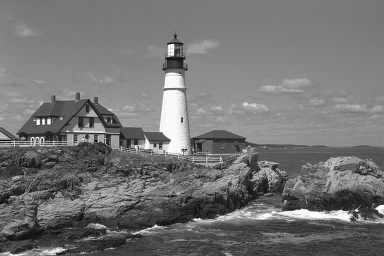

LH2


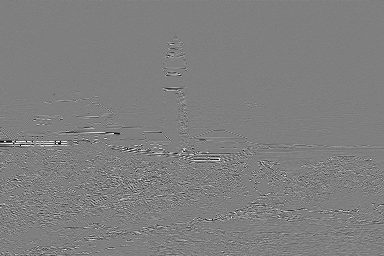

HL2


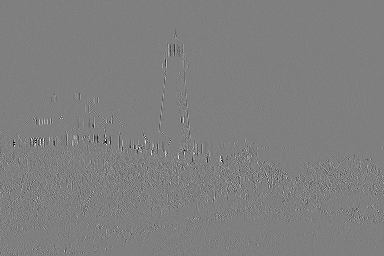

HH2


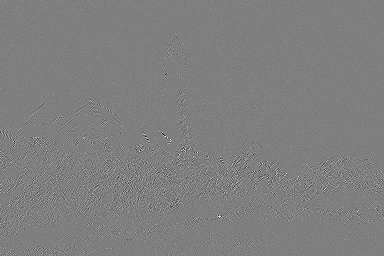

In [184]:
"""
Transformacja falkowa obrazu
"""


def dwt(img):
    """
    Bardzo prosta i podstawowa implementacja, nie uwzględniająca efektywnych metod obliczania DWT
    i dopuszczająca pewne niedokładności.
    """
    maskL = np.array([0.02674875741080976, -0.01686411844287795, -0.07822326652898785, 0.2668641184428723,
                      0.6029490182363579, 0.2668641184428723, -0.07822326652898785, -0.01686411844287795, 0.02674875741080976])
    maskH = np.array([0.09127176311424948, -0.05754352622849957, -0.5912717631142470, 1.115087052456994,
                      -0.5912717631142470, -0.05754352622849957, 0.09127176311424948])

    bandLL = cv2.sepFilter2D(img, -1, maskL, maskL)[::2, ::2]
    # ze względu na filtrację górnoprzepustową -> wartości ujemne, dlatego wynik 16-bitowy ze znakiem
    bandLH = cv2.sepFilter2D(img, cv2.CV_16S, maskL, maskH)[::2, ::2]
    bandHL = cv2.sepFilter2D(img, cv2.CV_16S, maskH, maskL)[::2, ::2]
    bandHH = cv2.sepFilter2D(img, cv2.CV_16S, maskH, maskH)[::2, ::2]

    return bandLL, bandLH, bandHL, bandHH


ll, lh, hl, hh = dwt(image_mono)
printi(ll, "LL")
printi(lh, "LH")
printi(hl, "HL")
printi(hh, "HH")

print()

print("LL2")
show_image(ll)
# cv2.multiply() -> zwiększenie kontrastu obrazów 'H', żeby lepiej uwidocznić
print("LH2")
show_image(cv2.multiply(lh, 2))
print("HL2")
show_image(cv2.multiply(hl, 2))
print("HH2")
show_image(cv2.multiply(hh, 2))


Wyznaczyć histogramy i obliczyć entropię dla wszystkich pasm.

H(LL) = 7.0584 
H(LH) = 5.1162 
H(HL) = 4.5131 
H(HH) = 5.0061 
H_śr = 5.4234


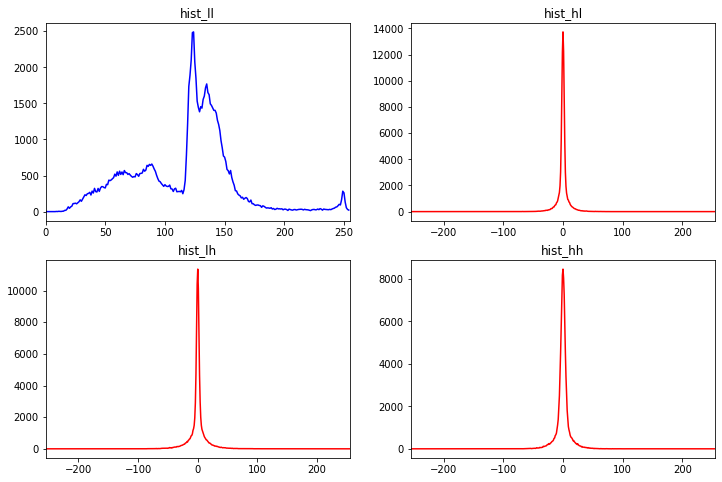

In [188]:
""" Entropia dla obrazów pasmowych """
hist_ll = generate_histogram(ll, 256)
# zmiana zakresu wartości i typu danych ze względu na cv2.calcHist() (jak wcześniej przy obrazach różnicowych)
hist_lh = generate_histogram((lh+255).astype(np.uint16), 512)
hist_hl = generate_histogram((hl+255).astype(np.uint16), 512)
hist_hh = generate_histogram((hh+255).astype(np.uint16), 512)

H_ll = calculate_entropy(hist_ll)
H_lh = calculate_entropy(hist_lh)
H_hl = calculate_entropy(hist_hl)
H_hh = calculate_entropy(hist_hh)
print(f"H(LL) = {H_ll:.4f} \nH(LH) = {H_lh:.4f} \nH(HL) = {H_hl:.4f} \nH(HH) = {H_hh:.4f} \nH_śr = {(H_ll+H_lh+H_hl+H_hh)/4:.4f}")

""" Wyświetlenie histogramów - jeden obraz z czterema pod-obrazami """
fig = plt.figure()
fig.set_figheight(fig.get_figheight()*2)  # zwiększenie rozmiarów okna
fig.set_figwidth(fig.get_figwidth()*2)
plt.subplot(2, 2, 1)
plt.plot(hist_ll, color="blue")
plt.title("hist_ll")
plt.xlim([0, 255])
plt.subplot(2, 2, 3)
plt.plot(np.arange(-255, 256, 1), hist_lh, color="red")
plt.title("hist_lh")
plt.xlim([-255, 255])
plt.subplot(2, 2, 2)
plt.plot(np.arange(-255, 256, 1), hist_hl, color="red")
plt.title("hist_hl")
plt.xlim([-255, 255])
plt.subplot(2, 2, 4)
plt.plot(np.arange(-255, 256, 1), hist_hh, color="red")
plt.title("hist_hh")
plt.xlim([-255, 255])

plt.show()  # wyświetlenie okien i oczekiwanie na ich zamnkięcie


> Porównać wyniki (histogram, entropia) uzyskane dla poszczególnych pasm między sobą  (czy któreś się  wyróżniają  i  dlaczego?) oraz z wynikami uzyskanymi dla obrazu oryginalnego i obrazu różnicowego.

...

# Obraz Barwny

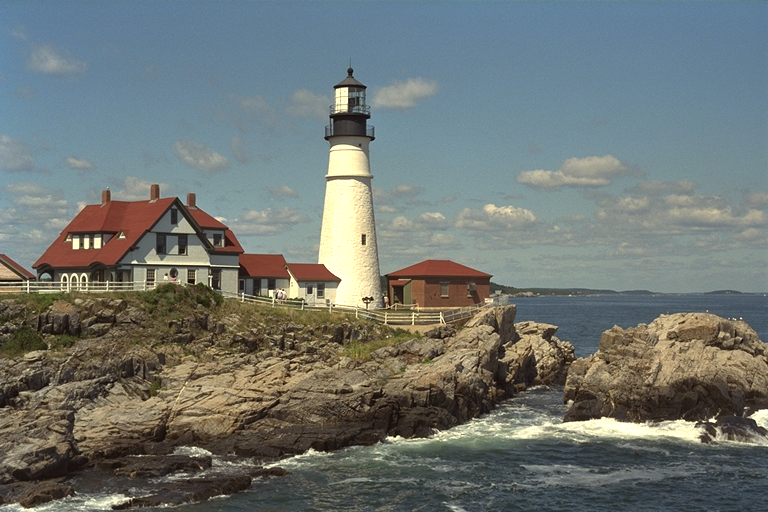

In [ ]:
image_col = cv2.imread(IMAGE_COL, cv2.IMREAD_UNCHANGED)
show_image(image_col)

Obliczyć entropię dla składowych RGB barwnego obrazu testowego.  

Dokonać konwersji z RGB do YUV i obliczyć entropię dla składowych YUV.   

Wyznaczyć histogramy dla wszystkich składowych.   

Porównać wyniki uzyskane dla poszczególnych składowych. Czy  dla składowych UV  entropia  jest mniejsza? Z czego ta mniejsza wartość może wynikać? 

Wyznaczyć zależność zniekształcenia D od przepływności R (liczba bitów przypadającą na jeden piksel obrazu): D = f(R) – tzw. krzywa R-D – dla kodera JPEG.  

Regulacji stopnia kompresji (przepływności R) należy dokonywać ustawiając wartości parametru `quality` przy zapisie obrazu do pliku. Wartości parametru `quality` należy dobrać tak, aby uzyskać `gładkie` wykresy.  

Jako miarę zniekształceń należy użyć szczytowy stosunek sygnału do szumu PSNR i błąd średniokwadratowy MSE.  

Zobrazować zależności na wykresach (oddzielny wykres dla każdej miary).

Dokonać subiektywnej oceny obrazów zrekonstruowanych (według własnej skali ocen, np.: jakość doskonała, bardzo dobra, dobra, średnia, kiepska, zła, bardzo zła, itp., lub: zniekształcenia niewidoczne, lekko widoczne, widoczne, bardzo widoczne, nie do przyjęcia, itp.) i zamieścić te oceny w sprawozdaniu (niekoniecznie dla każdego obrazu wynikowego osobno, raczej `zgrupować` oceny 
dla pewnych zakresów przepływności).

Porównać stopnie kompresji uzyskiwane dla kodera JPEG ze stopniem kompresji uzyskanym dla kodera PNG (pamiętając, że w pierwszej części laboratorium wykorzystywany był monochromatyczny obraz PNG, a kompresja JPEG była wykonywana dla obrazu barwnego; ewentualnie wyliczyć przepływność bitową dla obrazu barwnego skompresowanego koderem PNG). 